In [1]:
import numpy as np

In [2]:
EVT_DVS = 0  # DVS event type
EVT_APS = 1  # APS event

def read_bits(arr, mask=None, shift=None):
    if mask is not None:
        arr = arr & mask
    if shift is not None:
        arr = arr >> shift
    return arr


y_mask = 0x7FC00000
y_shift = 22

x_mask = 0x003FF000
x_shift = 12

polarity_mask = 0x800
polarity_shift = 11

valid_mask = 0x80000000
valid_shift = 31


def skip_header(fp):
    p = 0
    lt = fp.readline()
    ltd = lt.decode().strip()
    while ltd and ltd[0] == "#":
        p += len(lt)
        lt = fp.readline()
        try:
            ltd = lt.decode().strip()
        except UnicodeDecodeError:
            break
    return p


def load_raw_events(fp,
                    bytes_skip=0,
                    bytes_trim=0,
                    filter_dvs=False,
                    times_first=False):
    p = skip_header(fp)
    fp.seek(p + bytes_skip)
    data = fp.read()
    if bytes_trim > 0:
        data = data[:-bytes_trim]
    data = np.fromstring(data, dtype='>u4')
    if len(data) % 2 != 0:
        print(data[:20:2])
        print('---')
        print(data[1:21:2])
        raise ValueError('odd number of data elements')
    raw_addr = data[::2]
    timestamp = data[1::2]
    if times_first:
        timestamp, raw_addr = raw_addr, timestamp
    if filter_dvs:
        valid = read_bits(raw_addr, valid_mask, valid_shift) == EVT_DVS
        timestamp = timestamp[valid]
        raw_addr = raw_addr[valid]
    return timestamp, raw_addr


def parse_raw_address(addr,
                      x_mask=x_mask,
                      x_shift=x_shift,
                      y_mask=y_mask,
                      y_shift=y_shift,
                      polarity_mask=polarity_mask,
                      polarity_shift=polarity_shift):
    polarity = read_bits(addr, polarity_mask, polarity_shift).astype(np.bool_)
    x = read_bits(addr, x_mask, x_shift)
    y = read_bits(addr, y_mask, y_shift)
    return x, y, polarity


def load_events(
        fp,
        filter_dvs=False,
        **kwargs):
    timestamp, addr = load_raw_events(
        fp,
        filter_dvs=filter_dvs,
    )
    x, y, polarity = parse_raw_address(addr, **kwargs)
    return timestamp, x, y, polarity

In [3]:
import os

import argparse
import pickle as pkl
from Dataset import Dataset
from model import *
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

C:\Users\nikos\AppData\Local\Temp\ipykernel_17264\130972913.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')


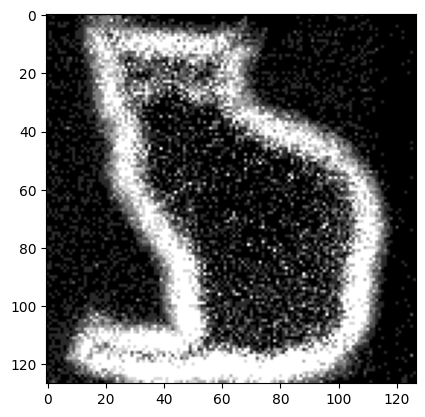

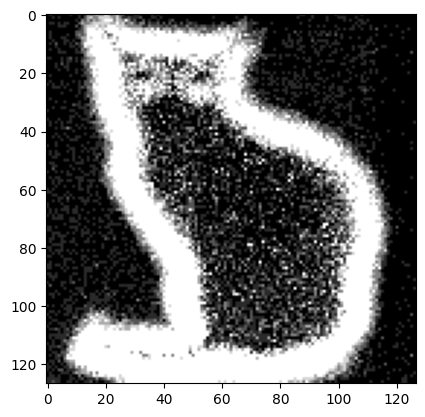

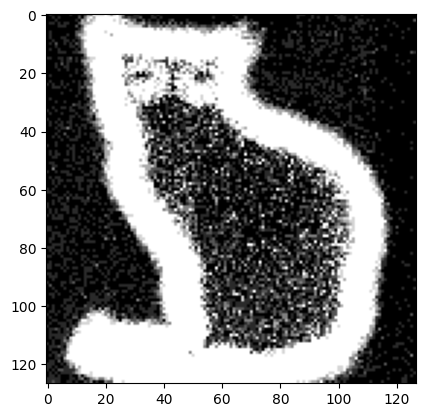

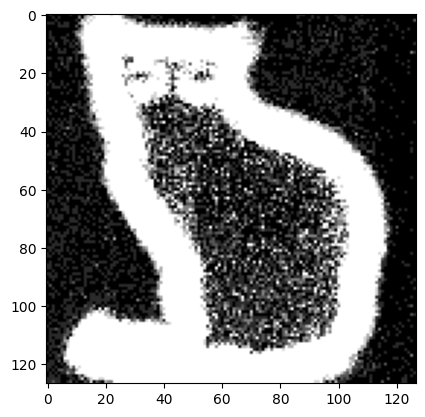

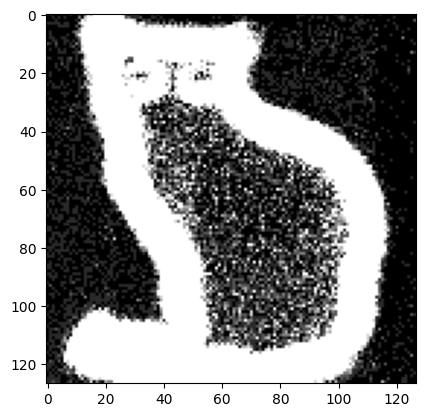

127 127


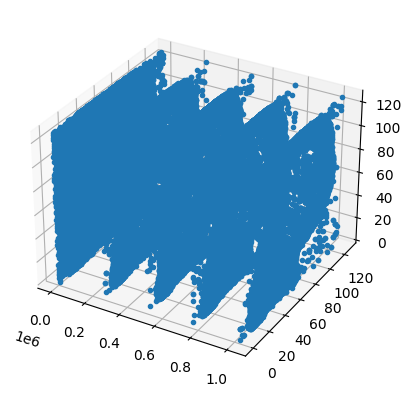

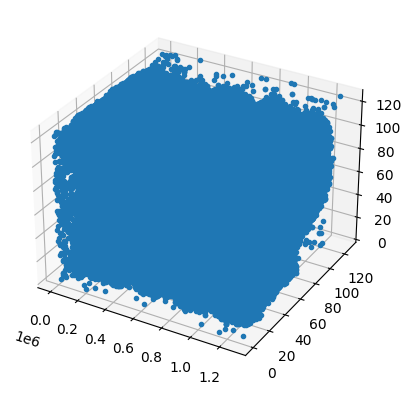

In [4]:

event_file = "Datasety\CIFAR10-DVS\cat\cifar10_cat_100.aedat"
with open(event_file, 'rb') as fp:
    t, x, y, p = load_events(fp,
                x_mask=0xfE,
                x_shift=1,
                y_mask=0x7f00,
                y_shift=8,
                polarity_mask=1,
                polarity_shift=None)

    events = {'t': t, 'x': 127 - y, 'y': 127 - x, 'p': 1 - p.astype(int)}

    noBins = 5
    tau = 0.6
    alpha = 0.1
    
    pic = np.zeros((2*noBins,128,128))
    pic3D = []
    pic3D_quantized = []
    temp_x = 0   
    temp_y = 0
    delta_t = (np.max(t)+0.00001)/noBins
    for event in range(len(events['t'])):
        t,x,y,p = events['t'][event], events["x"][event],events["y"][event],events["p"][event]
        temp_x = max(temp_x, x)
        temp_y = max(temp_y, y)
        for i in range(int(np.floor(float(t)/delta_t)), noBins):
            pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
        
        pic3D_quantized.append([int(np.floor(float(t)/delta_t)) * delta_t,x,y])
        pic3D.append([t,x,y])
    
    pic = np.array(pic)
    for i in range(noBins):
        pic2 = pic[i,:temp_y,:temp_x]
        plt.gray()
        plt.imshow(pic2)
        plt.show()



    ax = plt.figure().add_subplot(projection='3d')
    pic3D_quantized = np.array(pic3D_quantized)
    ax.plot(pic3D_quantized[:,0], pic3D_quantized[:,1], pic3D_quantized[:,2], '.')


    ax = plt.figure().add_subplot(projection='3d')
    pic3D = np.array(pic3D)
    ax.plot(pic3D[:,0], pic3D[:,1], pic3D[:,2], '.')
    print(temp_x, temp_y)

In [5]:
print(np.max(events['x']))
print(np.max(events['y']))

127
127


In [6]:
print(events)

{'t': array([      0,       0,       5, ..., 1282383, 1282385, 1282451],
      dtype=uint32), 'x': array([91, 27, 69, ..., 99, 55, 38], dtype=uint32), 'y': array([106, 120, 121, ...,  93,  14, 123], dtype=uint32), 'p': array([0, 1, 1, ..., 0, 0, 0])}


In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import scipy
import argparse
import pickle as pkl
from Dataset import Dataset
from model import *
import time
from copy import deepcopy

from tqdm import tqdm

In [8]:


noBins = 3
tau = 0.8
alpha = 0.1
name_dirs = [
"airplane",
"automobile"
]

dataset_x = []
dataset_y = []

train_dir = "C:/D/time_to_spike/in_torch/Datasety/CIFAR10-DVS/"
for num, label_name in enumerate(name_dirs):
    print(f"{num} : {label_name}")
    for filename, _ in zip(os.listdir(train_dir+label_name),tqdm(range(len(os.listdir(train_dir+label_name))))):
        with open(train_dir+label_name+'/'+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

        events = {}
        events['x'] = x
        events['y'] = y
        events['t'] = t
        events['p'] = p

        max_x = 128
        max_y = 128
        delta_t = (float(events['t'][-1])+0.00001)/noBins
        pic = np.zeros((noBins*2,max_y,max_x),dtype= np.float32)
        for event in range(len(events['t'])):
            t,x,y,p = events['t'][event], events['x'][event], events['y'][event], events['p'][event]
            for i in range(int(np.floor(float(t)/delta_t)), noBins):
                pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
            #pic[y,x] += t*(p-0.5)*2 #*t
        # pic = gausianBlur3D(pic)
        # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        normalized_image = pic
        dataset_x.append(normalized_image)
        dataset_y.append(num)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

0 : airplane


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp\ipykernel_17264\130972913.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [33:09<00:01,  1.99s/it]


1 : automobile


100%|█████████▉| 999/1000 [42:13<00:02,  2.54s/it]


In [9]:
dir_dataset = "Datasety/"
np.save(dir_dataset + 'CIFAR10-DVS1_128_x.npy', dataset_x)
np.save(dir_dataset + 'CIFAR10-DVS1_128_y.npy', dataset_y)

In [10]:
noBins = 3
tau = 0.8
alpha = 0.1
name_dirs = [
"bird",
"cat",
"deer"
]

dataset_x = []
dataset_y = []

train_dir = "C:/D/time_to_spike/in_torch/Datasety/CIFAR10-DVS/"
for num, label_name in enumerate(name_dirs):
    print(f"{num} : {label_name}")
    for filename, _ in zip(os.listdir(train_dir+label_name),tqdm(range(len(os.listdir(train_dir+label_name))))):
        with open(train_dir+label_name+'/'+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

        events = {}
        events['x'] = x
        events['y'] = y
        events['t'] = t
        events['p'] = p

        max_x = 128
        max_y = 128
        delta_t = (float(events['t'][-1])+0.00001)/noBins
        pic = np.zeros((noBins*2,max_y,max_x),dtype= np.float32)
        for event in range(len(events['t'])):
            t,x,y,p = events['t'][event], events['x'][event], events['y'][event], events['p'][event]
            for i in range(int(np.floor(float(t)/delta_t)), noBins):
                pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
            #pic[y,x] += t*(p-0.5)*2 #*t
        # pic = gausianBlur3D(pic)
        # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        normalized_image = pic
        dataset_x.append(normalized_image)
        dataset_y.append(num)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

0 : bird


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp\ipykernel_17264\130972913.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [33:36<00:02,  2.02s/it]


1 : cat


100%|█████████▉| 999/1000 [37:06<00:02,  2.23s/it]


2 : deer


100%|█████████▉| 999/1000 [34:57<00:02,  2.10s/it]


In [11]:
dir_dataset = "Datasety/"
np.save(dir_dataset + 'CIFAR10-DVS2_128_x.npy', dataset_x)
np.save(dir_dataset + 'CIFAR10-DVS2_128_y.npy', dataset_y)

In [12]:
noBins = 3
tau = 0.8
alpha = 0.1
name_dirs = [
"dog",
"frog"
]

dataset_x = []
dataset_y = []

train_dir = "C:/D/time_to_spike/in_torch/Datasety/CIFAR10-DVS/"
for num, label_name in enumerate(name_dirs):
    print(f"{num} : {label_name}")
    for filename, _ in zip(os.listdir(train_dir+label_name),tqdm(range(len(os.listdir(train_dir+label_name))))):
        with open(train_dir+label_name+'/'+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

        events = {}
        events['x'] = x
        events['y'] = y
        events['t'] = t
        events['p'] = p

        max_x = 128
        max_y = 128
        delta_t = (float(events['t'][-1])+0.00001)/noBins
        pic = np.zeros((noBins*2,max_y,max_x),dtype= np.float32)
        for event in range(len(events['t'])):
            t,x,y,p = events['t'][event], events['x'][event], events['y'][event], events['p'][event]
            for i in range(int(np.floor(float(t)/delta_t)), noBins):
                pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
            #pic[y,x] += t*(p-0.5)*2 #*t
        # pic = gausianBlur3D(pic)
        # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        normalized_image = pic
        dataset_x.append(normalized_image)
        dataset_y.append(num)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

0 : dog


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\nikos\AppData\Local\Temp\ipykernel_17264\130972913.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [38:17<00:02,  2.30s/it]


1 : frog


100%|█████████▉| 999/1000 [36:57<00:02,  2.22s/it]


In [13]:
dir_dataset = "Datasety/"
np.save(dir_dataset + 'CIFAR10-DVS3_128_x.npy', dataset_x)
np.save(dir_dataset + 'CIFAR10-DVS3_128_y.npy', dataset_y)

In [14]:
noBins = 3
tau = 0.8
alpha = 0.1
name_dirs = [
"horse",
"ship",
"truck"
]

dataset_x = []
dataset_y = []

train_dir = "C:/D/time_to_spike/in_torch/Datasety/CIFAR10-DVS/"
for num, label_name in enumerate(name_dirs):
    print(f"{num} : {label_name}")
    for filename, _ in zip(os.listdir(train_dir+label_name),tqdm(range(len(os.listdir(train_dir+label_name))))):
        with open(train_dir+label_name+'/'+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

        events = {}
        events['x'] = x
        events['y'] = y
        events['t'] = t
        events['p'] = p

        max_x = 128
        max_y = 128
        delta_t = (float(events['t'][-1])+0.00001)/noBins
        pic = np.zeros((noBins*2,max_y,max_x),dtype= np.float32)
        for event in range(len(events['t'])):
            t,x,y,p = events['t'][event], events['x'][event], events['y'][event], events['p'][event]
            for i in range(int(np.floor(float(t)/delta_t)), noBins):
                pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
            #pic[y,x] += t*(p-0.5)*2 #*t
        # pic = gausianBlur3D(pic)
        # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        normalized_image = pic
        dataset_x.append(normalized_image)
        dataset_y.append(num)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

0 : horse


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp\ipykernel_17264\130972913.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [41:33<00:02,  2.50s/it]


1 : ship


100%|█████████▉| 999/1000 [32:55<00:01,  1.98s/it]


2 : truck


100%|█████████▉| 999/1000 [42:29<00:02,  2.55s/it]


In [15]:
dir_dataset = "Datasety/"
np.save(dir_dataset + 'CIFAR10-DVS4_128_x.npy', dataset_x)
np.save(dir_dataset + 'CIFAR10-DVS4_128_y.npy', dataset_y)

In [16]:
print(name_dirs.__len__())

3


In [17]:
# dir_dataset = "Datasety/"
# np.save(dir_dataset + 'CIFAR10-DVS_x.npy', dataset_x)
# np.save(dir_dataset + 'CIFAR10-DVS_y.npy', dataset_y)

### concatenate

In [18]:
dir_dataset = "Datasety/"
ds1 = np.load(dir_dataset + "CIFAR10-DVS1_128_x.npy")
ds2 = np.load(dir_dataset + "CIFAR10-DVS2_128_x.npy")
ds3 = np.load(dir_dataset + "CIFAR10-DVS3_128_x.npy")
ds4 = np.load(dir_dataset + "CIFAR10-DVS4_128_x.npy")

In [19]:
ds = np.concatenate([ds1,ds2,ds3,ds4])

In [20]:
print(ds.shape)

(10000, 6, 128, 128)


In [21]:
print([ds1.shape,ds2.shape,ds3.shape,ds4.shape])

[(2000, 6, 128, 128), (3000, 6, 128, 128), (2000, 6, 128, 128), (3000, 6, 128, 128)]


In [ ]:
np.save(dir_dataset+"CIFAR10-DVS_128_exp_x.npy", ds)

In [ ]:
ds1_label = np.load(dir_dataset + "CIFAR10-DVS1_128_y.npy")
ds2_label = np.load(dir_dataset + "CIFAR10-DVS2_128_y.npy")
ds3_label = np.load(dir_dataset + "CIFAR10-DVS3_128_y.npy")
ds4_label = np.load(dir_dataset + "CIFAR10-DVS4_128_y.npy")

In [24]:
ds_label = np.concatenate([ds1_label,ds2_label+2,ds3_label+5,ds4_label+7])

In [25]:
print(ds_label.shape)

(10000,)


In [26]:
print(max(ds_label))

9


In [ ]:
np.save(dir_dataset + "CIFAR10-DVS_128_exp_y.npy", ds_label)